In [ ]:
!pip install evaluate # Installing the evaluate lib
!pip install datasets
!pip install plotly
!pip install librosa
!pip install statsmodels
!pip install transformers
!pip install accelerate -U

In [3]:
# Importing Libraries

# Data Handling
import pandas as pd
import numpy as np
from datasets import Dataset, load_dataset
import shutil
from IPython.display import Audio

# Data Visualization
import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots as sp
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.io as pio
from IPython.display import display
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
import librosa
import matplotlib.pyplot as plt
import librosa.display

#sklearn
from sklearn.model_selection import train_test_split

# Statistics & Mathematics
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import shapiro, skew, anderson, kstest, gaussian_kde,spearmanr
import math

# PyTorch
import torch

# Hiding warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Transformers
from transformers import AutoFeatureExtractor
from transformers import AutoModelForAudioClassification
from transformers import TrainingArguments
from transformers import Trainer

# Evaluate
import evaluate

2024-06-13 21:20:31.642670: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512_VNNI
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-13 21:20:32.040696: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [5]:
# Checking if GPU is available
if torch.cuda.is_available():
    print("GPU is available. \nUsing GPU")
    device = torch.device('cuda')
else:
    print("GPU is not available. \nUsing CPU")
    device = torch.device('cpu')

GPU is available. 
Using GPU


In [4]:
!nvidia-smi # Checking GPU

Thu Jun 13 08:34:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:CA:00.0 Off |                  Off |
| N/A   29C    P0              51W / 400W |      8MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [7]:
seed = 42
paper_color = '#f5f7f6'
bg_color = '#f5f7f6'
colormap = 'cividis'

In [8]:
df = load_dataset("marsyas/gtzan")

In [9]:
df

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 999
    })
})

In [10]:
df = df['train'].train_test_split(seed = seed, shuffle = True, 
                                  test_size = .2)

In [11]:
df

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 799
    })
    test: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 200
    })
})

In [12]:
df['train']['file'][0]

'/home/scur0997/.cache/huggingface/datasets/downloads/extracted/94bc194caed791abee9fd50c17fed0004b62f11d83f3f2fd4216b5826b82b038/genres/rock/rock.00012.wav'

In [13]:
df['train']['audio'][0]

{'path': '/home/scur0997/.cache/huggingface/datasets/downloads/extracted/94bc194caed791abee9fd50c17fed0004b62f11d83f3f2fd4216b5826b82b038/genres/rock/rock.00012.wav',
 'array': array([-0.006073  ,  0.0144043 ,  0.04669189, ..., -0.00701904,
        -0.01977539, -0.02853394]),
 'sampling_rate': 22050}

In [14]:
df['train']['genre'][0]

9

In [15]:
from datasets import Dataset, DatasetDict, Value, Features
import os

def load_fma_dataset(data_dir):
    # Example: Assuming `data_dir` is the path to your 'fma_small/000' directory
    
    # List all mp3 files
    file_paths = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir) if filename.endswith('.wav')]
    
    # Create a dataset from the file paths
    features = Features({
        'file_path': Value('string'),  # or any other features you need
    })
    
    dataset = Dataset.from_dict({
        'file_path': file_paths,
    }, features=features)

    return dataset

# Load the dataset
data_dir = '/home/scur0997/mma_2024/dataset/data/fma_small_wav/000'
fma_dataset = load_fma_dataset(data_dir)

print(fma_dataset)


Dataset({
    features: ['file_path'],
    num_rows: 62
})


In [16]:
fma_dataset['file_path'][0]

'/home/scur0997/mma_2024/dataset/data/fma_small_wav/000/000546.wav'

In [17]:
df = fma_dataset.train_test_split(seed = seed, shuffle = True, 
                                  test_size = .2)

In [18]:
df

DatasetDict({
    train: Dataset({
        features: ['file_path'],
        num_rows: 49
    })
    test: Dataset({
        features: ['file_path'],
        num_rows: 13
    })
})

In [19]:
import datasets

# Mock example to create a dataset
features = datasets.Features({
    'genre': datasets.ClassLabel(names=['classical', 'jazz', 'rock', 'pop'])
})
data = {'genre': [0, 1, 2, 3]}
ds = datasets.Dataset.from_dict(data, features=features)

# Converting integers to strings
genre_label = ds.features['genre'].int2str(2)  # Outputs 'rock'
print("Genre label:", genre_label)

# Converting strings to integers
genre_index = ds.features['genre'].str2int('rock')  # Outputs 2
print("Genre index:", genre_index)


Genre label: rock
Genre index: 2


In [20]:
genre_label = ds.features['genre'].int2str
print(genre_label)

<bound method ClassLabel.int2str of ClassLabel(names=['classical', 'jazz', 'rock', 'pop'], id=None)>


## Model

In [21]:
# Loading model
model = "ntu-spml/distilhubert"

# Instantiating feature extractor
feature_extractor = AutoFeatureExtractor.from_pretrained(model, do_normalize = True, return_attention_mask = True)

In [22]:
# Checking sampling rate
sampling_rate = feature_extractor.sampling_rate
print(f'DistilHuBERT Sampling Rate: {sampling_rate} Hz')

DistilHuBERT Sampling Rate: 16000 Hz


In [54]:
from datasets import load_dataset, Dataset, DatasetDict
import pandas as pd

# Example data frame
data = {
    'audio': [
                # '/home/scur0997/mma_2024/dataset/data/fma_small_wav/000/000002.wav', 
              # '/home/scur0997/mma_2024/dataset/data/fma_small_wav/000/000005.wav',
             '/home/scur0997/.cache/huggingface/datasets/downloads/extracted/94bc194caed791abee9fd50c17fed0004b62f11d83f3f2fd4216b5826b82b038/genres/disco/disco.00088.wav']
}
df = pd.DataFrame(data)

# Convert DataFrame to Dataset
dataset = Dataset.from_pandas(df)

# Structure this into a DatasetDict if needed
dataset_dict = DatasetDict({
    'train': dataset
})
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['audio'],
        num_rows: 1
    })
})

In [53]:
from datasets import Audio

# Initialize Audio with default parameters
audio_feature = Audio(sampling_rate=16000)

# Apply the Audio feature with default settings to the 'audio' column
dataset_dict = dataset_dict.cast_column('audio', audio_feature)

# Now accessing an item will automatically process the audio with default settings
audio_sample = dataset_dict['train']['audio'][0]
print(audio_sample)

# Now accessing an item will automatically process the audio with default settings
audio_sample = dataset_dict['train']['audio'][0]
print(audio_sample)



{'path': '/home/scur0997/.cache/huggingface/datasets/downloads/extracted/94bc194caed791abee9fd50c17fed0004b62f11d83f3f2fd4216b5826b82b038/genres/disco/disco.00088.wav', 'array': array([ 0.03352893,  0.05795968,  0.09609948, ..., -0.03805662,
        0.00101843,  0.01898582]), 'sampling_rate': 16000}
{'path': '/home/scur0997/.cache/huggingface/datasets/downloads/extracted/94bc194caed791abee9fd50c17fed0004b62f11d83f3f2fd4216b5826b82b038/genres/disco/disco.00088.wav', 'array': array([ 0.03352893,  0.05795968,  0.09609948, ..., -0.03805662,
        0.00101843,  0.01898582]), 'sampling_rate': 16000}


In [43]:
sample = dataset_dict['train']['audio'][0]
print(type(sample['array']))

<class 'numpy.ndarray'>


In [26]:
sample = dataset_dict['train']['audio'][0]
print(sample)

{'path': '/home/scur0997/.cache/huggingface/datasets/downloads/extracted/94bc194caed791abee9fd50c17fed0004b62f11d83f3f2fd4216b5826b82b038/genres/disco/disco.00088.wav', 'array': array([ 0.03352893,  0.05795968,  0.09609948, ..., -0.03805662,
        0.00101843,  0.01898582]), 'sampling_rate': 16000}


In [27]:
print('\nExample Data:\n')
print(f" Mean: {np.mean(sample['array']):.3}\n")
print(f" Variance: {np.var(sample['array']):.3}\n")


Example Data:

 Mean: 7.63e-05

 Variance: 0.0171



In [28]:
# Normalizing audio data
inputs = feature_extractor(sample['array'], sampling_rate = sample['sampling_rate'])

print(f"\nInputs Keys: {list(inputs.keys())}\n")

print(
    f" Mean: {np.mean(inputs['input_values']):.3}, Variance: {np.var(inputs['input_values']):.3}"
)


Inputs Keys: ['input_values', 'attention_mask']

 Mean: -5.14e-09, Variance: 1.0


In [29]:
max_duration = 30.0 # 30 seconds
inputs = feature_extractor(sample['array'],
                              sampling_rate = feature_extractor.sampling_rate,
                              max_length = int(feature_extractor.sampling_rate * max_duration),
                              truncation = True,
                              return_attention_mask = True)
print(inputs)

{'input_values': [array([ 0.2557941 ,  0.4426029 ,  0.7342374 , ..., -1.0909528 ,
       -1.1494174 , -0.60567755], dtype=float32)], 'attention_mask': [array([1, 1, 1, ..., 1, 1, 1], dtype=int32)]}


In [30]:
len(inputs['attention_mask'][0])

480000

### Finetunning

In [31]:
num_labels = 8 # Obtaining the total number of labels

# Loading model
hubert_model = AutoModelForAudioClassification.from_pretrained(model,
                                                         num_labels = 8,
                                                         # label2id=label2id,
                                                         # id2label=id2label
                                                              )

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at ntu-spml/distilhubert and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
# Visualizing model's architecture
print('\nHuBERT Architecture')
print(hubert_model) 


HuBERT Architecture
HubertForSequenceClassification(
  (hubert): HubertModel(
    (feature_extractor): HubertFeatureEncoder(
      (conv_layers): ModuleList(
        (0): HubertGroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1): HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (2): HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (3): HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (4): HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), st

In [33]:
# Setting training arguments
training_args = TrainingArguments(
    output_dir = 'hubert_gtzan',
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy',
    learning_rate = 5e-5,
    seed = seed,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,
    gradient_accumulation_steps = 1,
    num_train_epochs = 15,
    warmup_ratio = 0.1,
    fp16 = True,
    save_total_limit = 2,
    report_to = 'none'
    )

In [34]:
# Loading `accuracy` metric from the evaluate library
metric = evaluate.load('accuracy')
# Creating function to compute accuracy
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis = 1)
    return metric.compute(predictions = predictions, references = eval_pred.label_ids)

In [35]:
# Setting trainer
trainer = Trainer(
    model=hubert_model, 
    args = training_args,
    train_dataset = df['train'],
    eval_dataset = df['test'],
    tokenizer = feature_extractor,
    compute_metrics = compute_metrics)

KeyError: 'train'

In [4]:
metadata_path = '/home/scur0997/mma_2024/dataset/data/fma_metadata/genres.csv'
metadata = pd.read_csv(metadata_path)
display(metadata)
print(metadata['title'].unique())

,genre_id,#tracks,parent,title,top_level
0,1,8693,38,Avant-Garde,38
1,2,5271,0,International,2
2,3,1752,0,Blues,3
3,4,4126,0,Jazz,4
4,5,4106,0,Classical,5
...,...,...,...,...,...
158,1032,60,102,Turkish,2
159,1060,30,46,Tango,2
160,1156,26,130,Fado,2
161,1193,72,763,Christmas,38


['Avant-Garde' 'International' 'Blues' 'Jazz' 'Classical' 'Novelty'
 'Comedy' 'Old-Time / Historic' 'Country' 'Pop' 'Disco' 'Rock'
 'Easy Listening' 'Soul-RnB' 'Electronic' 'Sound Effects' 'Folk'
 'Soundtrack' 'Funk' 'Spoken' 'Hip-Hop' 'Audio Collage' 'Punk' 'Post-Rock'
 'Lo-Fi' 'Field Recordings' 'Metal' 'Noise' 'Psych-Folk' 'Krautrock'
 'Jazz: Vocal' 'Experimental' 'Electroacoustic' 'Ambient Electronic'
 'Radio Art' 'Loud-Rock' 'Latin America' 'Drone' 'Free-Folk' 'Noise-Rock'
 'Psych-Rock' 'Bluegrass' 'Electro-Punk' 'Radio' 'Indie-Rock' 'Industrial'
 'No Wave' 'Free-Jazz' 'Experimental Pop' 'French' 'Reggae - Dub'
 'Afrobeat' 'Nerdcore' 'Garage' 'Indian' 'New Wave' 'Post-Punk' 'Sludge'
 'African' 'Freak-Folk' 'Jazz: Out' 'Progressive' 'Alternative Hip-Hop'
 'Death-Metal' 'Middle East' 'Singer-Songwriter' 'Ambient' 'Hardcore'
 'Power-Pop' 'Space-Rock' 'Polka' 'Balkan' 'Unclassifiable' 'Europe'
 'Americana' 'Spoken Weird' 'Interview' 'Black-Metal' 'Rockabilly'
 'Easy Listening: Vocal' 

### FMA to GTZAN

In [2]:
import pandas as pd

# Adjust the path to where your metadata CSV file is located
metadata_path = '/home/scur0997/mma_2024/dataset/data/fma_metadata/tracks.csv'
metadata = pd.read_csv(metadata_path)

# Inspect the first few rows to understand the structure
# display(metadata.head())
# print(metadata.columns)
# print(metadata.iloc[0])
display(metadata[['Unnamed: 0','track.7']].head(20))
print(metadata['track.7'].unique())


/scratch-local/scur0997.6634938/ipykernel_2940992/72493711.py:5: DtypeWarning: Columns (0,1,5,6,8,12,18,20,21,22,24,33,34,38,39,44,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(metadata_path)


,Unnamed: 0,track.7
0,NaN,genre_top
1,track_id,NaN
2,2,Hip-Hop
3,3,Hip-Hop
4,5,Hip-Hop
5,10,Pop
6,20,NaN
7,26,NaN
8,30,NaN
9,46,NaN


['genre_top' nan 'Hip-Hop' 'Pop' 'Rock' 'Experimental' 'Folk' 'Jazz'
 'Electronic' 'Spoken' 'International' 'Soul-RnB' 'Blues' 'Country'
 'Classical' 'Old-Time / Historic' 'Instrumental' 'Easy Listening']


In [21]:
import pandas as pd

# Load the metadata
metadata_path = '/home/scur0997/mma_2024/dataset/data/fma_metadata/tracks.csv'
metadata = pd.read_csv(metadata_path, low_memory=False)

# It seems your DataFrame might have an extra initial row that needs to be dropped
# metadata = metadata.drop(0)  # Drops the first row if it's not part of the actual data

# Rename the columns for easier access
metadata = metadata[['Unnamed: 0','track.7']]


# # Drop rows where genre or track_id is NaN
metadata = metadata.dropna(subset=['Unnamed: 0','track.7'])

metadata.columns = ['track_id', 'genre']

# # Convert track_id to integer if it's not
metadata['track_id'] = metadata['track_id'].astype(int)
selected_genres = ['Hip-Hop', 'Pop', 'Folk', 'Experimental', 'Rock', 'International', 'Electronic', 'Instrumental']
# metadata = metadata[metadata['genre'].isin(selected_genres)]

display(metadata)



,track_id,genre
2,2,Hip-Hop
3,3,Hip-Hop
4,5,Hip-Hop
5,10,Pop
11,134,Hip-Hop
...,...,...
106570,155315,Rock
106571,155316,Rock
106572,155317,Rock
106573,155318,Rock


In [22]:
import os

# Define the base path where the genres directories will be
base_genre_path = '/home/scur0997/mma_2024/dataset/data/fma_small_gtzan/genres/'

for genre in selected_genres:
    genre_dir = os.path.join(base_genre_path, genre)
    os.makedirs(genre_dir, exist_ok=True)

In [23]:
# import shutil

# # Base directory where original FMA files are spread across subfolders
# base_fma_path = '/home/scur0997/mma_2024/dataset/data/fma_small_wav/'

# for subdir in os.listdir(base_fma_path):
#     subdir_path = os.path.join(base_fma_path, subdir)
#     if os.path.isdir(subdir_path):
#         for filename in os.listdir(subdir_path):
#             if filename.endswith('.wav'):
#                 # Extract track ID from filename
#                 track_id = int(filename.split('.')[0])
#                 # Find genre from metadata
#                 genre_row = metadata[metadata['track_id'] == track_id]
#                 if not genre_row.empty:
#                     genre = genre_row['genre'].values[0]
#                     new_filename = f"{genre.lower()}.{filename}"
#                     source_path = os.path.join(subdir_path, filename)
#                     target_path = os.path.join(base_genre_path, genre, new_filename)
#                     shutil.move(source_path, target_path)


In [2]:
!pip install pydub

Defaulting to user installation because normal site-packages is not writeable
  Using cached pydub-0.25.1-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pydub-0.25.1-py2.py3-none-any.whl (32 kB)


In [ ]:
import os
import subprocess
from pydub import AudioSegment
import pandas as pd

# Load the CSV files
metadata_path = '/scratch-shared/scur0997/fma_medium/fma_metadata/tracks.csv'   # Update this path if needed
metadata = pd.read_csv(metadata_path, low_memory=False)

# Clean up and rename columns
metadata = metadata[['Unnamed: 0', 'track.7']].dropna(subset=['Unnamed: 0', 'track.7'])
metadata.columns = ['track_id', 'genre']
metadata['track_id'] = metadata['track_id'].astype(int)

# Define the genres of interest
target_genres = ["rock", "reggae-dub"]

# Set the base path for the FMA dataset and the target path for the new dataset
base_fma_path = '/scratch-shared/scur0997/fma_medium/'  # Update this path
base_genre_path = '/home/scur0997/mma_2024/dataset/data/fma_small_gtzan/missing_genres/'  # Update this path

# Create the target directories if they don't exist
os.makedirs(os.path.join(base_genre_path, 'rock'), exist_ok=True)
os.makedirs(os.path.join(base_genre_path, 'metal'), exist_ok=True)
os.makedirs(os.path.join(base_genre_path, 'reggae-dub'), exist_ok=True)

# Function to check if an audio file is corrupted
def is_corrupted(file_path):
    try:
        # Run ffmpeg to check the file
        result = subprocess.run(
            ['ffmpeg', '-v', 'error', '-i', file_path, '-f', 'null', '-'],
            stdout=subprocess.PIPE, stderr=subprocess.PIPE
        )
        # If there is no error, the file is not corrupted
        return result.returncode != 0
    except Exception as e:
        print(f"An error occurred while checking {file_path}: {e}")
        return True

# Filter and process tracks for each genre
for genre in target_genres:
    genre_tracks = metadata[metadata['genre'].str.lower() == genre]
    rock_count = 0
    metal_count = 0
    
    for _, row in genre_tracks.iterrows():
        if rock_count >= 100 and metal_count >= 100:
            break
        
        track_id = row['track_id']
        mp3_filename = f"{track_id}.mp3"
        subdir = str(track_id // 1000).zfill(3)  # FMA organizes tracks in subdirectories by their IDs
        source_path = os.path.join(base_fma_path, subdir, mp3_filename)
        
        if os.path.exists(source_path) and not is_corrupted(source_path):
            # Convert MP3 to WAV
            audio = AudioSegment.from_mp3(source_path)
            
            if rock_count < 100:
                wav_filename = f"rock.{str(track_id).zfill(6)}.wav"  # Format: rock.000000.wav
                target_path = os.path.join(base_genre_path, 'rock', wav_filename)
                rock_count += 1
            else:
                wav_filename = f"metal.{str(track_id).zfill(6)}.wav"  # Format: metal.000000.wav
                target_path = os.path.join(base_genre_path, 'metal', wav_filename)
                metal_count += 1
            
            audio.export(target_path, format="wav")
            print(f"Processed and converted: {source_path} to {target_path}")
        else:
            print(f"File {source_path} is corrupted or does not exist and will be skipped.")
    
    print(f"{rock_count} tracks processed for genre rock.")
    print(f"{metal_count} tracks processed for genre metal.")

print("Track organization and conversion complete.")


## Start Preprocessing

In [26]:
from datasets import Dataset, DatasetDict, Value, ClassLabel, Features, Audio
import os
from tqdm.notebook import tqdm

def create_dataset_from_directory(data_dir, genre_feature, max_files_per_genre=100):
    # Collect all audio files and their genres
    data_files = []
    genres = []

    for genre in tqdm(os.listdir(data_dir), desc='Processing genres'):
        genre_dir = os.path.join(data_dir, genre)
        if os.path.isdir(genre_dir):
            file_count = 0  # Initialize a counter for files per genre
            for file in tqdm(os.listdir(genre_dir), desc=f'Loading {genre} files'):
                if file.endswith('.wav'):
                    # if file_count < max_files_per_genre:  # Check if the limit has been reached
                    file_path = os.path.join(genre_dir, file)
                    data_files.append(file_path)
                    genres.append(genre_feature.str2int(genre))  # Convert genre string to int
                    file_count += 1  # Increment the file counter
                    # else:
                    #     break  # Stop processing more files if the limit is reached

    # Define custom features for the dataset using the Audio feature
    features = Features({
        'file': Value('string'),
        'audio': Audio(sampling_rate=16000),  # Use the Audio feature to handle the audio data
        'genre': genre_feature
    })

    # Create the dataset
    dataset = Dataset.from_dict({
        'file': data_files,
        'audio': data_files,  # Reuse file paths directly for the audio feature
        'genre': genres
    }, features=features)

    return dataset

def load_fma_dataset(root_dir):
    # genre_names = ['Hip-Hop', 'Pop', 'Folk', 'Experimental', 'Rock', 'International', 'Electronic', 'Instrumental']
    # {'0': 'blues', '1': 'classical', '2': 'country', '3': 'disco', '4': 'hiphop', '5': 'jazz', '6': 'metal', '7': 'pop', '8': 'reggae', '9': 'rock'}
    genre_names = ['blues', 'classical', 'country',  'disco', 'hiphop','jazz', 'metal', 'pop',  'reggae', 'rock']
    genre_feature = ClassLabel(names=genre_names)

    # Load all data
    full_dataset = create_dataset_from_directory(root_dir, genre_feature)
    
    # Split the dataset into train and test
    split_data = full_dataset.train_test_split(test_size=0.2)
    
    return DatasetDict({
        'train': split_data['train'],
        'test': split_data['test']
    })

# Assuming you have a root directory containing genre subdirectories with audio files
root_data_dir = '/home/scur0997/danilo/gtzan/genres/'
fma_dataset = load_fma_dataset(root_data_dir)


Processing genres:   0%|          | 0/10 [00:00<?, ?it/s]

Loading rock files:   0%|          | 0/200 [00:00<?, ?it/s]

Loading country files:   0%|          | 0/170 [00:00<?, ?it/s]

Loading pop files:   0%|          | 0/200 [00:00<?, ?it/s]

Loading metal files:   0%|          | 0/200 [00:00<?, ?it/s]

Loading jazz files:   0%|          | 0/99 [00:00<?, ?it/s]

Loading reggae files:   0%|          | 0/100 [00:00<?, ?it/s]

Loading classical files:   0%|          | 0/200 [00:00<?, ?it/s]

Loading disco files:   0%|          | 0/141 [00:00<?, ?it/s]

Loading hiphop files:   0%|          | 0/169 [00:00<?, ?it/s]

Loading blues files:   0%|          | 0/119 [00:00<?, ?it/s]

In [9]:
fma_dataset

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 1279
    })
    test: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 320
    })
})

In [10]:
fma_dataset['file'][0]

KeyError: 'file'

In [17]:
fma_dataset['genre'][0]

4

In [18]:
genre_names = ['Hip-Hop', 'Pop', 'Folk', 'Experimental', 'Rock', 'International', 'Electronic', 'Instrumental']  
genre_feature = ClassLabel(names=genre_names)
print(genre_feature)

ClassLabel(names=['Hip-Hop', 'Pop', 'Folk', 'Experimental', 'Rock', 'International', 'Electronic', 'Instrumental'], id=None)


In [23]:
fma_dataset['file'][1222]

'/home/scur0997/mma_2024/dataset/data/fma_small_gtzan/genres/Pop/pop.129372.wav'

In [25]:
fma_dataset['genre'][1222]

1

In [26]:
fma_dataset['file'][5000]

'/home/scur0997/mma_2024/dataset/data/fma_small_gtzan/genres/Hip-Hop/hip-hop.082780.wav'

In [ ]:
fma_dataset['audio']['file'][5000]

In [68]:
from datasets import Dataset, DatasetDict, Value, ClassLabel, Features, Audio
import os
from tqdm.notebook import tqdm

def create_dataset_from_directory(data_dir, genre_feature):
    # Collect all audio files and their genres
    data_files = []
    genres = []

    # Break after processing 1 genre for debugging
    for genre in tqdm(os.listdir(data_dir), desc='Processing genres'):
        genre_dir = os.path.join(data_dir, genre)
        if os.path.isdir(genre_dir):
            # Break after processing 1 file in the genre for debugging
            for file in tqdm(os.listdir(genre_dir), desc=f'Loading {genre} files'):
                if file.endswith('.wav'):
                    file_path = os.path.join(genre_dir, file)
                    data_files.append(file_path)
                    genres.append(genre_feature.str2int(genre))  # Convert genre string to int
                # break  # Stop after one file
        # break  # Stop after one genre

    # Define custom features for the dataset using the Audio feature
    features = Features({
        'file': Value('string'),
        'audio': Audio(sampling_rate=16000),  # Use the Audio feature to handle the audio data
        'genre': genre_feature
    })

    # Create the dataset
    dataset = Dataset.from_dict({
        'file': data_files,
        'audio': data_files,  # Reuse file paths directly for the audio feature
        'genre': genres
    }, features=features)

    return dataset

def load_fma_dataset(root_dir):
    genre_names = ['Hip-Hop', 'Pop', 'Folk', 'Experimental', 'Rock', 'International', 'Electronic', 'Instrumental']
    genre_feature = ClassLabel(names=genre_names)

    # Load all data
    full_dataset = create_dataset_from_directory(root_dir, genre_feature)
    
    # return full_dataset
    # Split the dataset into train and test
    split_data = full_dataset.train_test_split(test_size=0.2)
    
    return DatasetDict({
        'train': split_data['train'],
        'test': split_data['test']
    })

# Assuming you have a root directory containing genre subdirectories with audio files
root_data_dir = '/home/scur0997/mma_2024/dataset/data/fma_small_gtzan/genres/'
fma_dataset = load_fma_dataset(root_data_dir)

# Debug print to check the structure of a sample
# print(f"Sample data: {fma_dataset['train'][0]}")


Processing genres:   0%|          | 0/8 [00:00<?, ?it/s]

Loading Rock files:   0%|          | 0/1000 [00:00<?, ?it/s]

Loading Pop files:   0%|          | 0/1000 [00:00<?, ?it/s]

Loading Electronic files:   0%|          | 0/1000 [00:00<?, ?it/s]

Loading Folk files:   0%|          | 0/1000 [00:00<?, ?it/s]

Loading Experimental files:   0%|          | 0/1000 [00:00<?, ?it/s]

Loading Hip-Hop files:   0%|          | 0/1000 [00:00<?, ?it/s]

Loading Instrumental files:   0%|          | 0/1000 [00:00<?, ?it/s]

Loading International files:   0%|          | 0/1000 [00:00<?, ?it/s]

In [69]:
fma_dataset

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 6400
    })
    test: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 1600
    })
})

In [60]:
print(fma_dataset['audio'][0]['path'])
print(fma_dataset['file'][0])
print(fma_dataset['genre'][0])
print(type(fma_dataset['audio'][0]['array']))
print(fma_dataset['audio'][0]['array'][:20])

/home/scur0997/mma_2024/dataset/data/fma_small_gtzan/genres/Rock/rock.099260.wav
/home/scur0997/mma_2024/dataset/data/fma_small_gtzan/genres/Rock/rock.099260.wav
4
<class 'numpy.ndarray'>
[-4.05838385e-09 -6.42494200e-08  6.54504078e-08 -9.60964144e-08
  4.23862865e-08 -6.84082977e-08  1.83245049e-07 -1.75229076e-07
  1.78244136e-07 -1.79195752e-07  2.36273365e-07 -2.01742210e-07
  1.98643576e-07 -2.40439078e-07  2.02903749e-07 -1.35739711e-07
  1.80082679e-07 -9.26054611e-08  9.27692838e-08 -5.57223956e-08]


In [64]:
print(fma_dataset['audio'][0])

{'path': '/home/scur0997/mma_2024/dataset/data/fma_small_gtzan/genres/Rock/rock.099260.wav', 'array': array([-4.05838385e-09, -6.42494200e-08,  6.54504078e-08, ...,
        8.05342615e-01,  6.81615472e-01,  0.00000000e+00]), 'sampling_rate': 16000}


In [72]:
# Picking the third file in the training dataset
print("file:", fma_dataset['train'][2]['file']) 
print('\n')
print("audio: ", fma_dataset['train'][2]['audio']) 
print('\n')
print("genre:", fma_dataset['train'][2]['genre']) 
print('\n')

file: /home/scur0997/mma_2024/dataset/data/fma_small_gtzan/genres/Pop/pop.016340.wav


audio:  {'path': '/home/scur0997/mma_2024/dataset/data/fma_small_gtzan/genres/Pop/pop.016340.wav', 'array': array([-2.49624810e-09,  7.50026707e-11,  3.30279626e-09, ...,
       -3.70567739e-02, -4.47870158e-02,  0.00000000e+00]), 'sampling_rate': 16000}


genre: 1




In [27]:
df = fma_dataset
id2label_function = df['train'].features['genre'].int2str

In [13]:
print("genre: ", id2label_function(df['train'][2]['genre']))

genre:  classical


In [21]:
# Initializing variables
sampling_rate_check = None
all_same = True

# Iterating through each sample
for set_name in ['train', 'test']: # Iterating through both sets
    for sample in df[set_name]:
        sampling_rate = sample['audio']['sampling_rate']

        if sampling_rate_check is None:
            sampling_rate_check = sampling_rate
        else:
            if sampling_rate != sampling_rate_check:
                all_same = False
            break
        
# Printing result
if all_same:
    print(f"All samples have the same sampling rate: {sampling_rate_check} Hz")
else:
    print("The samples in the dataframe have different sampling rates.")

All samples have the same sampling rate: 16000 Hz


In [ ]:
# Configuring notebook
seed = 42
paper_color = '#f5f7f6'
bg_color = '#f5f7f6'
colormap = 'cividis'

labels = {} # Initializing empty list

# Defining a function to count labels 
def count_genres(df):
    for sample in df:
        genre_label = id2label_function(sample['genre'])
        
        if genre_label in labels:
            labels[genre_label] += 1
            
        else:
            labels[genre_label] = 1
            
# Counting labels in both sets
count_genres(df['train'])
count_genres(df['test'])

# Obtaining genres and count values
genres = list(labels.keys())
counts = list(labels.values())

# Plotting bar plot 
fig = px.bar(x = genres, y = counts, text = counts)
fig.update_traces(marker=dict(color="#4682B4"))
fig.update_layout(title = '<b>Genre Counts</b>', showlegend = True, height = 500, width = 750,
                 plot_bgcolor=bg_color,paper_bgcolor=paper_color)
fig.update_yaxes(title_text = '<b>Count</b>')
fig.update_xaxes(title = '<b>Genres</b>')

fig.show()

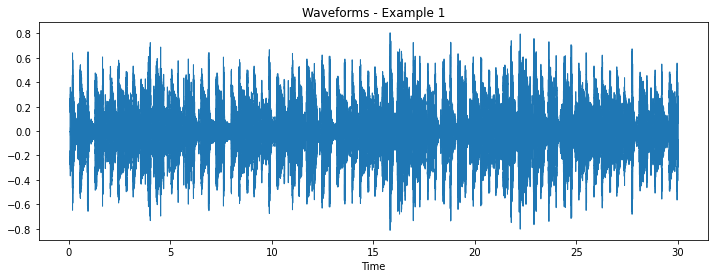

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

# Selecting array sound & sampling rate
array = df['train'][2]['audio']['array']
sampling_rate = df['train'][2]['audio']['sampling_rate']

# Plotting waveform with librosa
plt.figure().set_figwidth(12)
plt.title('Waveforms - Example 1')
librosa.display.waveshow(array, sr = sampling_rate)
plt.show()

In [9]:
# Displaying audio file
Audio(data = array, rate = sampling_rate)

In [10]:
# Printing genre
print("file: ", df['train'][2]['file'])
print("genre: ", id2label_function(df['train'][2]['genre']))

file:  /home/scur0997/mma_2024/dataset/data/fma_small_gtzan/genres/Pop/pop.016340.wav
genre:  Pop


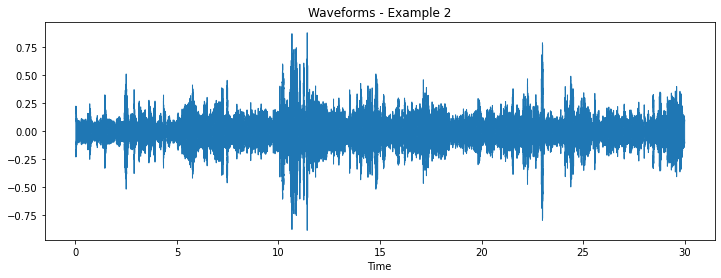

In [90]:
import matplotlib.pyplot as plt
%matplotlib inline

array = df['train'][14]['audio']['array']
sampling_rate = df['train'][14]['audio']['sampling_rate']

plt.figure().set_figwidth(12)
plt.title('Waveforms - Example 2')
librosa.display.waveshow(array, sr = sampling_rate)
plt.show()

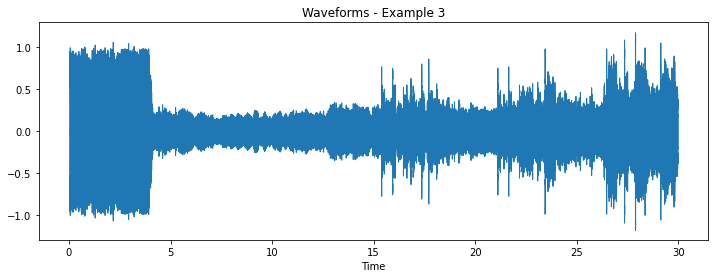

In [91]:
array = df['train'][42]['audio']['array']
sampling_rate = df['train'][42]['audio']['sampling_rate']

plt.figure().set_figwidth(12)

plt.title('Waveforms - Example 3')
librosa.display.waveshow(array, sr = sampling_rate)
plt.show()

In [92]:
Audio(data = array, rate = sampling_rate)

In [93]:
print("genre: ", id2label_function(df['train'][42]['genre']))

genre:  Electronic


## Saving dataset

In [28]:
df.save_to_disk('/scratch-shared/scur0997/fma_small_gtzan/dataset_processed_subset_augmented/')

Saving the dataset (0/8 shards):   0%|          | 0/1278 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/320 [00:00<?, ? examples/s]

In [13]:
from datasets import load_from_disk

# Load the dataset from disk
df = load_from_disk('/scratch-shared/scur0997/fma_small_gtzan/dataset_processed_subset_augmented')

## Let's cook

In [29]:
# Loading model
model = "/home/scur0997/danilo/mma_2024/src/models/checkpoint_tl"

# Instantiating feature extractor
feature_extractor = AutoFeatureExtractor.from_pretrained(model, do_normalize = True, return_attention_mask = True)

In [30]:
# Checking sampling rate
sampling_rate = feature_extractor.sampling_rate
print(f'DistilHuBERT Sampling Rate: {sampling_rate} Hz')

DistilHuBERT Sampling Rate: 16000 Hz


In [31]:
# Defining audio maximum duration
max_duration = 30.0 # 30 seconds

def preprocess_function(examples):
    # Extracting and saving arrays 
    audio_arrays = [x['array'] for x in examples['audio']]
    
    # Preprocessing audio inputs
    inputs = feature_extractor(audio_arrays,
                              sampling_rate = feature_extractor.sampling_rate,
                              max_length = int(feature_extractor.sampling_rate * max_duration),
                              truncation = True,
                              return_attention_mask = True)
    
    return inputs

In [32]:
# Preprocessing data
df = df.map(preprocess_function,
                   remove_columns = ['audio', 'file'],
                   batched = True,
                   batch_size = 100,
                   num_proc = None)

df # Visualizing results

Map:   0%|          | 0/1278 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['genre', 'input_values', 'attention_mask'],
        num_rows: 1278
    })
    test: Dataset({
        features: ['genre', 'input_values', 'attention_mask'],
        num_rows: 320
    })
})

In [35]:
# !df -h  # Check disk usage by partition
!du -sh "/home/scur0997/" #Check the size of specific directories

157G	/home/scur0997/


In [33]:
df.save_to_disk('/scratch-shared/scur0997/fma_small_gtzan/dataset_training_subset_augmented')

Saving the dataset (0/10 shards):   0%|          | 0/1278 [00:00<?, ? examples/s]

Saving the dataset (0/3 shards):   0%|          | 0/320 [00:00<?, ? examples/s]

## From Here

In [34]:
# Importing Libraries

# Data Handling
import pandas as pd
import numpy as np
from datasets import Dataset, load_dataset
import shutil
from IPython.display import Audio

# Data Visualization
import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots as sp
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.io as pio
from IPython.display import display
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
import librosa
import matplotlib.pyplot as plt
import librosa.display

#sklearn
from sklearn.model_selection import train_test_split

# Statistics & Mathematics
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import shapiro, skew, anderson, kstest, gaussian_kde,spearmanr
import math

# PyTorch
import torch

# Hiding warnings
import warnings
warnings.filterwarnings("ignore")

# Transformers
from transformers import AutoFeatureExtractor
from transformers import AutoModelForAudioClassification
from transformers import TrainingArguments
from transformers import Trainer
from transformers import AutoModelForAudioClassification, AutoConfig
from pathlib import Path
import os

# Evaluate
import evaluate

# Checking if GPU is available
if torch.cuda.is_available():
    print("GPU is available. \nUsing GPU")
    device = torch.device('cuda')
else:
    print("GPU is not available. \nUsing CPU")
    device = torch.device('cpu')
    
from datasets import load_from_disk

GPU is available. 
Using GPU


In [12]:
# Load the dataset from disk
df = load_from_disk('/scratch-shared/scur0997/fma_small_gtzan/dataset_training_subset')

# Obtaining human-readable label
id2label_function = df['train'].features['genre'].int2str
print(id2label_function)

# Renaming genre column
df = df.rename_column('genre', 'label')

id2label = {str(i): id2label_function(i)
           for i in range(len(df['train'].features['label'].names))}



# Label to id
label2id = {v: k for k, v in id2label.items()}
print(label2id)

num_labels = len(id2label) # Obtaining the total number of labels

<bound method ClassLabel.int2str of ClassLabel(names=['Hip-Hop', 'Pop', 'Folk', 'Experimental', 'Rock', 'International', 'Electronic', 'Instrumental'], id=None)>
{'Hip-Hop': '0', 'Pop': '1', 'Folk': '2', 'Experimental': '3', 'Rock': '4', 'International': '5', 'Electronic': '6', 'Instrumental': '7'}


# Fine-tunning

In [ ]:
def load_latest_checkpoint(checkpoint_dir):
    """
    Load the latest checkpoint from the given directory.
    Args:
        checkpoint_dir (str): Path to the directory containing model checkpoints.
    Returns:
        A PyTorch model loaded from the latest checkpoint.
    """
    # List all subdirectories in the checkpoint directory
    checkpoint_subdirs = [os.path.join(checkpoint_dir, d) for d in os.listdir(checkpoint_dir) if os.path.isdir(os.path.join(checkpoint_dir, d))]
    
    # Find the latest checkpoint directory
    latest_checkpoint = max(checkpoint_subdirs, key=os.path.getmtime)
    
    # Load the model configuration from the latest checkpoint
    config = AutoConfig.from_pretrained(latest_checkpoint)
    
    # Load the model from the latest checkpoint
    model = AutoModelForAudioClassification.from_pretrained(latest_checkpoint, config=config)

    return model

# Path to the directory containing all checkpoints
checkpoint_directory = '/home/scur0997/danilo/mma_2024/src/models/hubert_gtzan'  # Update this path

# Load the model
model = load_latest_checkpoint(checkpoint_directory)
print("Model loaded from:", model)


In [ ]:
# Loading model
model = "ntu-spml/distilhubert"

# Instantiating feature extractor
feature_extractor = AutoFeatureExtractor.from_pretrained(model, do_normalize = True, return_attention_mask = True)
# Loading model
hubert_model = AutoModelForAudioClassification.from_pretrained(model,
                                                         num_labels = num_labels,
                                                         label2id=label2id,
                                                         id2label=id2label)

In [8]:
# Configuring notebook
seed = 42
paper_color = '#f5f7f6'
bg_color = '#f5f7f6'
colormap = 'cividis'

# Setting training arguments
training_args = TrainingArguments(
    output_dir = 'hubert_gtzan',
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy',
    learning_rate = 5e-5,
    seed = seed,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    gradient_accumulation_steps = 1,
    num_train_epochs = 15,
    warmup_ratio = 0.1,
    fp16 = True,
    save_total_limit = 2,
    report_to = 'none'
    )

# Loading `accuracy` metric from the evaluate library
metric = evaluate.load('accuracy')
# Creating function to compute accuracy
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis = 1)
    return metric.compute(predictions = predictions, references = eval_pred.label_ids)

# Setting trainer
trainer = Trainer(
    model=hubert_model, 
    args = training_args,
    train_dataset = df['train'],
    eval_dataset = df['test'],
    tokenizer = feature_extractor,
    compute_metrics = compute_metrics)

In [ ]:
# Training
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.037036,0.281250
2,No log,1.887781,0.325000


In [ ]:
# Training
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.044696,0.262500
2,No log,1.888806,0.318750
3,No log,1.743539,0.368750
4,No log,1.672577,0.406250
5,No log,1.683029,0.425000
6,No log,1.545720,0.431250
7,No log,1.464209,0.481250
8,No log,1.518701,0.512500


In [ ]:
import numpy as np
from datasets import load_from_disk
from transformers import AutoConfig, AutoFeatureExtractor, AutoModelForAudioClassification, TrainingArguments, Trainer
import evaluate
import json
import os


# Load the dataset from disk
df = load_from_disk('/scratch-shared/scur0997/fma_small_gtzan/dataset_training_subset')

# Obtaining human-readable label
id2label_function = df['train'].features['genre'].int2str

# Renaming genre column
df = df.rename_column('genre', 'label')

id2label = {str(i): id2label_function(i)
           for i in range(len(df['train'].features['label'].names))}

# Label to id
label2id = {v: k for k, v in id2label.items()}

num_labels = len(id2label) # Obtaining the total number of labels

# Example usage
model = "/home/scur0997/danilo/mma_2024/src/models/checkpoint_tl"

# Instantiating feature extractor
feature_extractor = AutoFeatureExtractor.from_pretrained(model, do_normalize = True, return_attention_mask = True)
# Loading model
hubert_model = AutoModelForAudioClassification.from_pretrained(model,
                                                         num_labels = num_labels,
                                                         label2id=label2id,
                                                         id2label=id2label,
                                                         ignore_mismatched_sizes=True)

# Configure training
training_args = TrainingArguments(
    output_dir='checkpoints/finetuning/',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    learning_rate=5e-5,
    seed=42,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=1,
    num_train_epochs=15,
    warmup_ratio=0.1,
    fp16=True,
    save_total_limit=2,
    report_to='none'
)

# Load `accuracy` metric
metric = evaluate.load('accuracy')

# Function to compute metrics
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

# Configure and start training
trainer = Trainer(
    model=hubert_model,
    args=training_args,
    train_dataset=df['train'],
    eval_dataset=df['test'],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics
)

trainer.train()

# if latest_checkpoint:
#     print(f"Resuming training from the latest checkpoint at {latest_checkpoint}")
#     trainer.train(resume_from_checkpoint=latest_checkpoint)
# else:
#     print("Starting training from scratch.")
#     trainer.train()



Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at /home/scur0997/danilo/mma_2024/src/models/checkpoint_tl and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([10, 256]) in the checkpoint and torch.Size([8, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([10]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/scur0997/.local/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.964630,0.268750
2,No log,1.793097,0.350000
3,No log,1.687653,0.393750
4,No log,1.652611,0.406250
5,No log,1.691801,0.418750
6,No log,1.640683,0.450000
7,No log,1.680439,0.418750


## Drop and different Lr

In [ ]:
import numpy as np
from datasets import load_from_disk
from transformers import AutoConfig, AutoFeatureExtractor, AutoModelForAudioClassification, TrainingArguments, Trainer
import evaluate
import json
import os
import torch 

# Evaluate
import evaluate

# Checking if GPU is available
if torch.cuda.is_available():
    print("GPU is available. \nUsing GPU")
    device = torch.device('cuda')
else:
    print("GPU is not available. \nUsing CPU")
    device = torch.device('cpu')
    
from datasets import load_from_disk

# Load the dataset from disk
df = load_from_disk('/scratch-shared/scur0997/fma_small_gtzan/dataset_training_subset')

# Obtaining human-readable label
id2label_function = df['train'].features['genre'].int2str

# Renaming genre column
df = df.rename_column('genre', 'label')

id2label = {str(i): id2label_function(i)
           for i in range(len(df['train'].features['label'].names))}

# Label to id
label2id = {v: k for k, v in id2label.items()}

num_labels = len(id2label) # Obtaining the total number of labels

# Example usage
model = "/home/scur0997/danilo/mma_2024/src/models/checkpoint_tl"

# Instantiating feature extractor
feature_extractor = AutoFeatureExtractor.from_pretrained(model, do_normalize = True, return_attention_mask = True)
# Loading model
hubert_model = AutoModelForAudioClassification.from_pretrained(model,
                                                         num_labels = num_labels,
                                                         label2id=label2id,
                                                         id2label=id2label,
                                                         ignore_mismatched_sizes=True)

# Add dropout regularization
hubert_model.config.hidden_dropout_prob = 0.1
hubert_model.config.attention_probs_dropout_prob = 0.1

# Configure training
training_args = TrainingArguments(
    output_dir='checkpoints/finetuning/',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    learning_rate=3e-5,
    seed=42,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=1,
    num_train_epochs=15,
    warmup_ratio=0.1,
    fp16=True,
    save_total_limit=2,
    report_to='none'
)

# Load `accuracy` metric
metric = evaluate.load('accuracy')

# Function to compute metrics
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

# Configure and start training
trainer = Trainer(
    model=hubert_model,
    args=training_args,
    train_dataset=df['train'],
    eval_dataset=df['test'],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics
)

trainer.train()

# if latest_checkpoint:
#     print(f"Resuming training from the latest checkpoint at {latest_checkpoint}")
#     trainer.train(resume_from_checkpoint=latest_checkpoint)
# else:
#     print("Starting training from scratch.")
#     trainer.train()



GPU is available. 
Using GPU


Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at /home/scur0997/danilo/mma_2024/src/models/checkpoint_tl and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([10, 256]) in the checkpoint and torch.Size([8, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([10]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/scur0997/.local/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.980768,0.250000
2,No log,1.783829,0.368750
3,No log,1.651755,0.412500


## Cooking 🥘🧑‍🍳

In [1]:
# Importing Libraries

# Data Handling
import pandas as pd
import numpy as np
from datasets import Dataset, load_dataset
import shutil
from IPython.display import Audio

# Data Visualization
import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots as sp
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.io as pio
from IPython.display import display
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
import librosa
import matplotlib.pyplot as plt
import librosa.display

#sklearn
from sklearn.model_selection import train_test_split

# Statistics & Mathematics
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import shapiro, skew, anderson, kstest, gaussian_kde,spearmanr
import math


# Hiding warnings
import warnings
warnings.filterwarnings("ignore")

# Transformers
from transformers import AutoFeatureExtractor
from transformers import AutoModelForAudioClassification
from transformers import TrainingArguments
from transformers import Trainer

# Evaluate
import evaluate


# PyTorch
import torch

# Checking if GPU is available
if torch.cuda.is_available():
    print("GPU is available. \nUsing GPU")
    device = torch.device('cuda')
else:
    print("GPU is not available. \nUsing CPU")
    device = torch.device('cpu')

use_cuda = torch.cuda.is_available()

from datasets import load_from_disk


# Load the dataset from disk
df = load_from_disk('/scratch-shared/scur0997/fma_small_gtzan/dataset_training_subset_augmented')


# Obtaining human-readable label
id2label_function = df['train'].features['genre'].int2str

# Renaming genre column
df = df.rename_column('genre', 'label')

# Id to label
id2label = {str(i): id2label_function(i)
           for i in range(len(df['train'].features['label'].names))}

# Label to id
label2id = {v: k for k, v in id2label.items()}

num_labels = len(id2label) # Obtaining the total number of labels


# Example usage
# model = "/home/scur0997/danilo/mma_2024/src/models/checkpoint_tl"
model = "/home/scur0997/fame_of_god_models/checkpoint-480-79"

# Instantiating feature extractor
feature_extractor = AutoFeatureExtractor.from_pretrained(model, do_normalize = True, return_attention_mask = True)
# Loading model
hubert_model = AutoModelForAudioClassification.from_pretrained(model,
                                                         num_labels = num_labels,
                                                         label2id=label2id,
                                                         id2label=id2label)

# Setting training arguments
training_args = TrainingArguments(
    output_dir = 'hubert_gtzan_transfer_learning',
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy',
    learning_rate = 5e-5,
    seed = 42,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,
    gradient_accumulation_steps = 1,
    num_train_epochs = 15,
    warmup_ratio = 0.1,
    fp16 = True,
    save_total_limit = 2,
    report_to = 'none'
    )

# Loading `accuracy` metric from the evaluate library
metric = evaluate.load('accuracy')
# Creating function to compute accuracy
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis = 1)
    return metric.compute(predictions = predictions, references = eval_pred.label_ids)

2024-06-13 22:22:27.715651: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512_VNNI
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-13 22:22:28.135218: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


GPU is available. 
Using GPU


In [ ]:
# Setting trainer
trainer = Trainer(
    model=hubert_model, 
    args = training_args,
    train_dataset = df['train'],
    eval_dataset = df['test'],
    tokenizer = feature_extractor,
    compute_metrics = compute_metrics)

# Training
trainer.train()

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.757113,0.740625
2,No log,0.735791,0.759375
3,No log,0.665877,0.790625


In [ ]:
# Setting trainer
trainer = Trainer(
    model=hubert_model, 
    args = training_args,
    train_dataset = df['train'],
    eval_dataset = df['test'],
    tokenizer = feature_extractor,
    compute_metrics = compute_metrics)

# Training
trainer.train()

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.671878,0.806250
2,No log,0.925319,0.778125
3,No log,1.027701,0.787500
4,0.229300,1.079573,0.778125
